In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
df = pd.read_pickle("/homes/heng.ma/Research/ddmd/ddmd/examples/result.pkl")
df

,pdb,dcd,frame,rmsd,embeddings,lof_score,sys_label,gpu_id,cluster_label
0,1FME-unfolded.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,0,8.561428,"[1.6714863777160645, 0.30660271644592285, 2.55...",-1.005639,md_run_3_1658946649,3,48
1,1FME-unfolded.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,1,8.303156,"[1.6617140769958496, 0.002918193582445383, 2.5...",-1.022394,md_run_3_1658946649,3,48
2,1FME-unfolded.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,2,7.950052,"[1.7700068950653076, 0.13817985355854034, 2.78...",-1.047597,md_run_3_1658946649,3,48
3,1FME-unfolded.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,3,7.886427,"[1.784546136856079, -0.13907037675380707, 2.72...",-1.226015,md_run_3_1658946649,3,48
4,1FME-unfolded.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,4,8.048006,"[1.3434345722198486, 0.04127068445086479, 2.25...",-1.061781,md_run_3_1658946649,3,48
...,...,...,...,...,...,...,...,...,...
3230995,md_run_6_1659189478_000318.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,995,6.534321,"[-0.2969791293144226, 0.2759909927845001, -0.1...",-1.074222,md_run_7_1659379614,7,317
3230996,md_run_6_1659189478_000318.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,996,6.715948,"[-0.06121736019849777, 0.5191706418991089, -0....",-1.302381,md_run_7_1659379614,7,166
3230997,md_run_6_1659189478_000318.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,997,6.667552,"[-0.10843116790056229, 0.35775285959243774, -0...",-1.017979,md_run_7_1659379614,7,166
3230998,md_run_6_1659189478_000318.pdb,/scratch/heng/ddmd/folded_bba_test/md_run/md_r...,998,6.786375,"[-0.05550696700811386, 0.46440649032592773, 0....",-1.030362,md_run_7_1659379614,7,166


In [7]:
timeline = {}
pairs = []
for gpu_id in df.gpu_id.unique(): 
    timeline[f"gpu_{gpu_id}"] = []
    sub_df = df[df.gpu_id == gpu_id]
    for sys_label in tqdm(sub_df.sys_label.unique()): 
        current_time = int(sys_label.split('_')[-1]) - 1658946649
        timeline[f"gpu_{gpu_id}"].append(current_time)
        pdb = sub_df[sub_df.sys_label == sys_label]['pdb'].to_list()[0]
        if pdb.startswith('md_run'):      
            target = [current_time, int(gpu_id)]
            source = [int(pdb[:-4].split('_')[3])  - 1658946649, int(pdb[:-4].split('_')[2])]
            pairs.append([source, target])

100%|███████████████████████████████████████████████████████████████████████████████| 644/644 [00:19<00:00, 32.73it/s]


In [4]:
a="md_run_6_1681218718_000641.pdb"
a[:-4].split('_')[2]

'6'

In [8]:
%run ~/.mpl_set.py

Text(0.5, 0, 'MD steps')

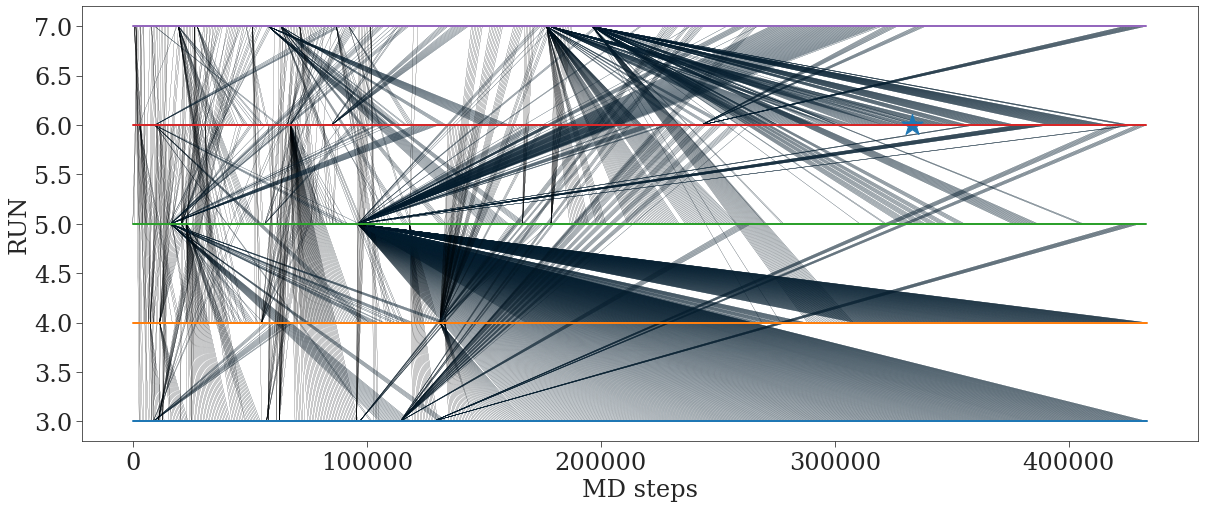

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))

for gpu_id in timeline: 
    ax.plot(timeline[gpu_id], np.ones_like(timeline[gpu_id]) * int(gpu_id[-1]), linewidth=2)
for pair in pairs: 
    pair = np.array(pair)
    dist = pair[1] - pair[0]
    ax.arrow(*pair[0], *dist, linewidth=.1)
    
ax.scatter([1659279412  - 1658946649], [6], marker='*', s=500)
ax.set_ylabel("RUN")
ax.set_xlabel("MD steps")

In [21]:
df.iloc[(np.argmin(df.rmsd))]

pdb                                 md_run_7_1659124858_000166.pdb
dcd              /scratch/heng/ddmd/folded_bba_test/md_run/md_r...
frame                                                          384
rmsd                                                      1.864422
embeddings       [-0.228046715259552, -0.9512129426002502, 0.60...
lof_score                                                -1.059139
sys_label                                      md_run_6_1659279412
gpu_id                                                           6
cluster_label                                                   45
Name: 2437384, dtype: object

In [6]:
def traj_stack(dtrajs): 
    y_len = max(len(i) for i in dtrajs)
    dtraj_stacks = np.ones([len(dtrajs), y_len]) * -1
    for i, dtraj in enumerate(dtrajs):
        dtraj_stacks[i, :len(dtraj)] = dtraj
    return dtraj_stacks[dtraj_stacks != -1]

In [7]:
dtrajs['total'] = traj_stack(dtrajs.values())

In [8]:
for i in dtrajs: 
    print(len(dtrajs[i]))

4000
7000
4000
3000
2000
20000


In [17]:
%%time
def sampling(traj): 
    sampled = []
    n_sampled = []
    for i in tqdm(traj): 
        if i not in sampled: 
            sampled.append(i)
        n_sampled.append(len(sampled))
    return None # n_sampled

sampling(dtrajs['total'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3231000/3231000 [00:15<00:00, 210116.50it/s]

CPU times: user 15.4 s, sys: 113 ms, total: 15.5 s
Wall time: 15.6 s


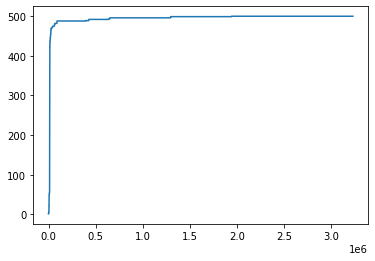

In [13]:
plt.plot(sampling(dtrajs['total']))

In [20]:
df.pdb.unique()

array(['/homes/heng.ma/Research/ddmd/ddmd/data/pdbs/bba/1FME-unfolded.pdb'],
      dtype=object)